In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor

In [2]:
# Load the dataset
data = pd.read_csv("train.csv")

In [3]:
print(data.describe())

                X2           X4           X6           X8            Y
count  4994.000000  6000.000000  6000.000000  6000.000000  6000.000000
mean     12.956536     0.066333   141.228200  1997.840333     7.303403
std       4.658851     0.051492    62.540569     8.334412     1.014361
min       4.555000     0.000000    31.290000  1985.000000     3.510000
25%       8.895000     0.027030    94.037650  1987.000000     6.750000
50%      12.800000     0.054620   143.197000  1999.000000     7.500000
75%      17.100000     0.095154   186.522050  2004.000000     8.040000
max      21.350000     0.328391   266.888400  2009.000000     9.400000


### 1. X4 heavy tailed might need bins or to take log
### 2. X6 multimodal might need bins
### 3. X8 years might need scaling or further processing

array([[<Axes: title={'center': 'X2'}>, <Axes: title={'center': 'X4'}>],
       [<Axes: title={'center': 'X6'}>, <Axes: title={'center': 'X8'}>],
       [<Axes: title={'center': 'Y'}>, <Axes: >]], dtype=object)

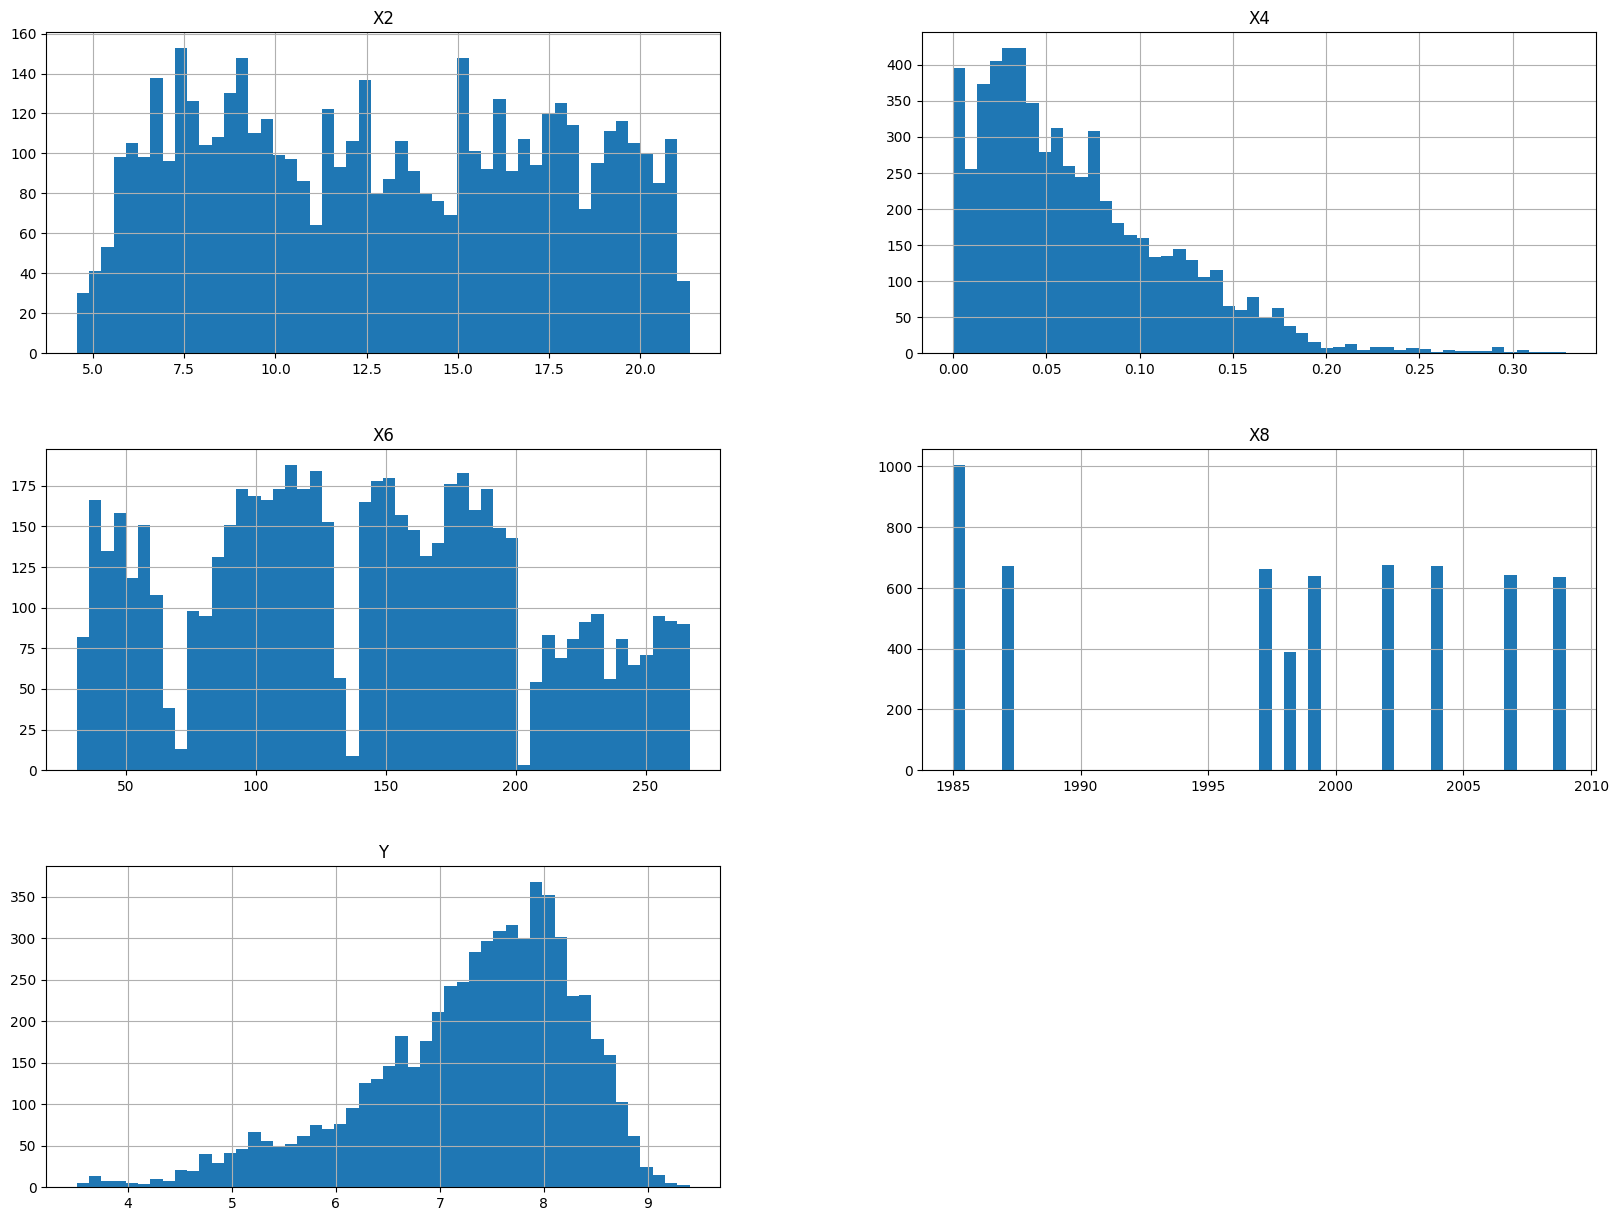

In [4]:
import matplotlib.pyplot as plt
import numpy as np

data.hist(bins=50, figsize=(20,15))

### Notice that X6 has a very high correlation stratified sampling can be a key

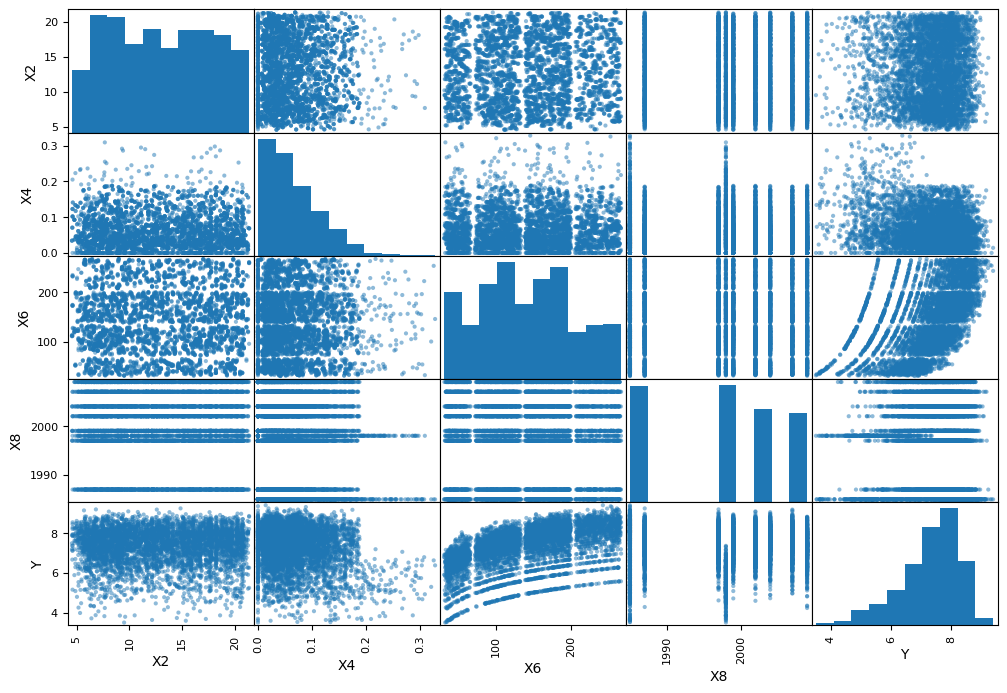

In [5]:
from pandas.plotting import scatter_matrix
x_num = data.select_dtypes(include=[np.number])
corr_matrix = x_num.corr()
scatter_matrix(x_num, figsize=(12, 8))  # No extra indentation
plt.show() 

In [6]:
X = data.drop(columns=['Y'])
y = data['Y']

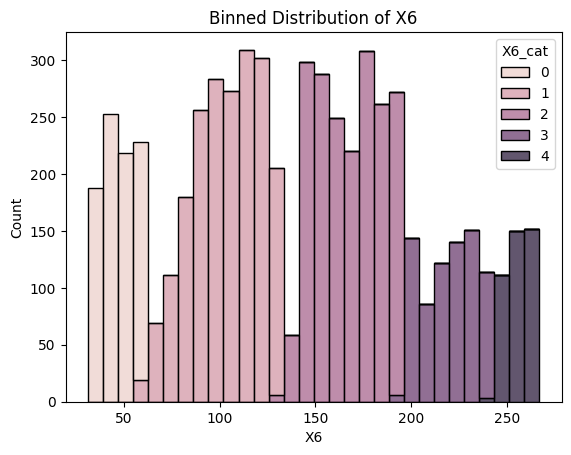

X6_cat
1    0.333500
2    0.325833
0    0.144667
3    0.126667
4    0.069333
Name: count, dtype: float64

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
bins = [0, 62, 133, 196, 243, 300]
X["X6_cat"] = pd.cut(X["X6"], bins=bins, labels=False)

sns.histplot(data=X, x="X6", hue="X6_cat", kde=False, bins=30, multiple="stack")
plt.title("Binned Distribution of X6")
plt.show()

X["X6_cat"].value_counts() / len(X)

### Plot feature importance using different models to select features

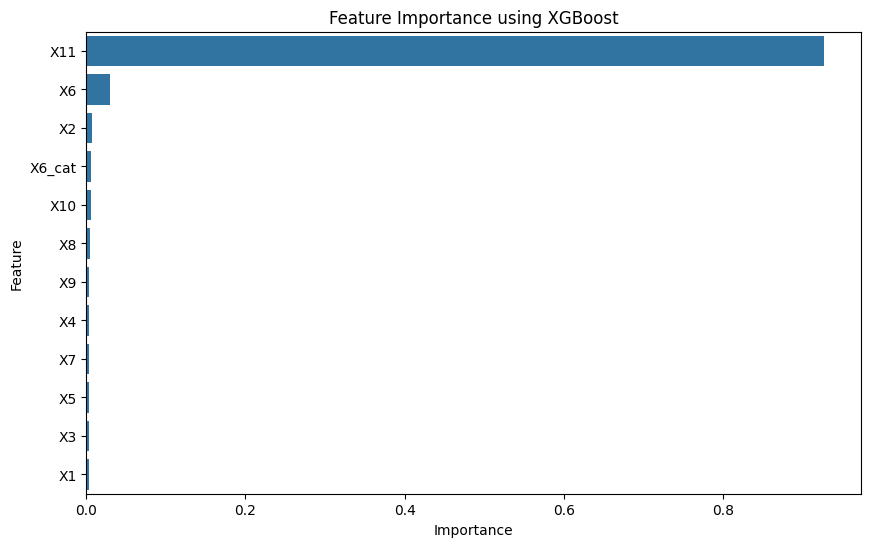

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)


importances = model_xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance using XGBoost')
plt.show()

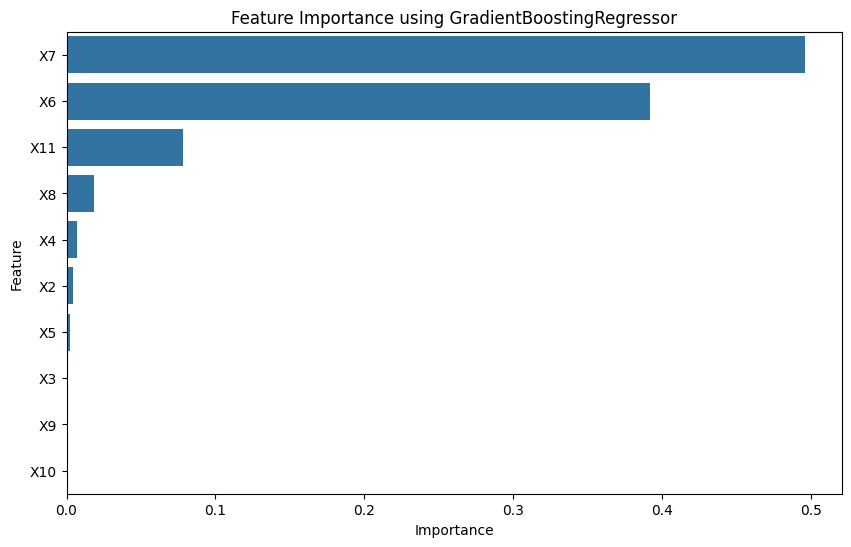

In [9]:
from category_encoders import TargetEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('train.csv')

# Assume 'Y' is your target variable
X = data.drop(columns=['Y', 'X1'])
y = data['Y']

# Encode categorical features using TargetEncoder
for column in X.select_dtypes(include=['object']).columns:
    le = TargetEncoder()
    X[column] = le.fit_transform(X[column], y)

# Define a pipeline with an imputer and the Gradient Boosting Regressor
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Get feature importance
importances = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance using GradientBoostingRegressor')
plt.show()

### Notice that the most important features are (X6, X7, X8, X11)

In [10]:

# Features and target
X = data.drop(["Y", "X1", "X2", "X3", "X4", "X5", "X9", "X10"], axis=1) 
y = data["Y"]

#Clustering X6 to create new feature (cluster labels)
kmeans = KMeans(n_clusters=7, random_state=42)
X['X6_cluster'] = kmeans.fit_predict(X[['X6']])

# Apply binning to X6 
X["X6_cat"] = pd.cut(
    X["X6"],
    bins=np.linspace(X["X6"].min(), X["X6"].max(), 24),
    labels=False,
    include_lowest=True
)

# Here I used the stratified sampling trick 
# because X6 has a very high correlation with the label y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=X["X6_cat"], random_state=42
)

x6_transformer = Pipeline(steps=[('scaler', RobustScaler())])
x7_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
x8_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
x11_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create the preprocessor with the additional cluster feature (X6_cluster)
preprocessor = ColumnTransformer(
    transformers=[
        ("X6", x6_transformer, ["X6"]),
        ("X7", x7_transformer, ["X7"]),
        ("X8", x8_transformer, ["X8"]),
        ("X11", x11_transformer, ["X11"])
    ]
)

# CatBoost model
model = CatBoostRegressor(random_seed=42, loss_function="MAE", eval_metric="MAE", verbose=0)

# Create a pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# Define parameter grid for GridSearchCV
param_grid = {
    "model__iterations": [500, 1000],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__depth": [6, 8, 10],
    "model__l2_leaf_reg": [3, 5, 7],
    "model__border_count": [128, 254],
}

# Cross-validation and grid search
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Best MAE:", mae)

/opt/anaconda3/envs/ai_lab_1/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'model__border_count': 128, 'model__depth': 6, 'model__iterations': 500, 'model__l2_leaf_reg': 7, 'model__learning_rate': 0.01}
Best MAE: 0.3884822766558958
